# Fixed Income Analytics: Valuation, Risk & Monte Carlo

## Project Overview
This project implements a robust framework for Fixed Income analysis. We move beyond simple pricing to sophisticated risk modeling.

**Key Objectives:**
1.  **Valuation:** Pricing models based on Discounted Cash Flow (DCF).
2.  **Risk Metrics:** Macaulay Duration, Modified Duration, and Convexity.
3.  **Visual Analysis:** Cash Flow time-structures and Price-Yield curves.
4.  **Stochastic Simulation:** Using Monte Carlo methods to estimate Value at Risk (VaR) under volatile rate environments.

---

In [1]:
# 1. IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Set visual styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("mako")
plt.rcParams['figure.figsize'] = (12, 7)

## 2. THEORETICAL FRAMEWORK & FUNCTIONS

We define the core financial mathematics functions here.

### Key Formulas

**1. Bond Price ($P$):**
$$P = \sum_{t=1}^{n} \frac{C}{(1+y/k)^t} + \frac{F}{(1+y/k)^n}$$

**2. Modified Duration ($D_{mod}$):**
$$D_{mod} = \frac{D_{mac}}{1 + y/k}$$

**3. Portfolio Duration:**
$$ D_{port} = \sum (w_i \times D_{mod, i}) $$
Where $w_i$ is the weight of the asset in the portfolio.

In [2]:
def calculate_bond_metrics(face_value, coupon_rate, ytm, years, freq=2):
    """
    Calculates Price, Macaulay Duration, Modified Duration, and Convexity.
    """
    c = coupon_rate * face_value / freq
    y = ytm / freq
    n = int(years * freq)
    periods = np.arange(1, n + 1)

    # Cash Flows
    cash_flows = np.full(n, c)
    cash_flows[-1] += face_value

    # Discount Factors
    discount_factors = 1 / ((1 + y) ** periods)

    # PV of Cash Flows
    pv_cash_flows = cash_flows * discount_factors
    price = np.sum(pv_cash_flows)

    # Macaulay Duration
    mac_duration_periods = np.sum(periods * pv_cash_flows) / price
    mac_duration_years = mac_duration_periods / freq

    # Modified Duration
    mod_duration = mac_duration_years / (1 + y)

    # Convexity
    convexity_term = periods * (periods + 1) * pv_cash_flows
    convexity = np.sum(convexity_term) / (price * ((1 + y) ** 2))
    convexity = convexity / (freq ** 2)

    return {
        'Price': price,
        'Macaulay_Duration': mac_duration_years,
        'Modified_Duration': mod_duration,
        'Convexity': convexity,
        'Cash_Flows': cash_flows,
        'Periods': periods / freq  # Convert to years for plotting
    }

## 3. INDIVIDUAL BOND ANALYSIS

We define three distinct bonds to represent different areas of the yield curve.

In [3]:
# Define Bond Characteristics
bonds_data = [
    {'id': 'Short-Term (2yr)', 'face': 1000, 'coupon': 0.02, 'years': 2, 'ytm': 0.04},
    {'id': 'Medium-Term (10yr)', 'face': 1000, 'coupon': 0.05, 'years': 10, 'ytm': 0.05},
    {'id': 'Long-Term (30yr)', 'face': 1000, 'coupon': 0.08, 'years': 30, 'ytm': 0.06}
]

# Calculate and Store Metrics
results = []
bond_objects = {} # Dictionary to store full objects for later access

for b in bonds_data:
    metrics = calculate_bond_metrics(b['face'], b['coupon'], b['ytm'], b['years'])
    bond_objects[b['id']] = metrics

    # Summary for DataFrame
    summary = {
        'Bond_ID': b['id'],
        'Price': metrics['Price'],
        'Coupon': b['coupon'],
        'YTM': b['ytm'],
        'Mod_Duration': metrics['Modified_Duration'],
        'Convexity': metrics['Convexity']
    }
    results.append(summary)

df_bonds = pd.DataFrame(results).set_index('Bond_ID')
display(df_bonds.round(4))

,Price,Coupon,YTM,Mod_Duration,Convexity
Bond_ID,,,,,
Short-Term (2yr),961.9227,0.02,0.04,1.9312,4.7093
Medium-Term (10yr),1000.0000,0.05,0.05,7.7946,73.6287
Long-Term (30yr),1276.7556,0.08,0.06,13.1603,271.3882


## 4. VISUALIZING CASH FLOW STRUCTURES

Duration is often described as the "weighted average time to receive cash flows." By plotting the actual payments, we can visually see why the 30-year bond carries so much more risk—the bulk of the money comes back decades from now.

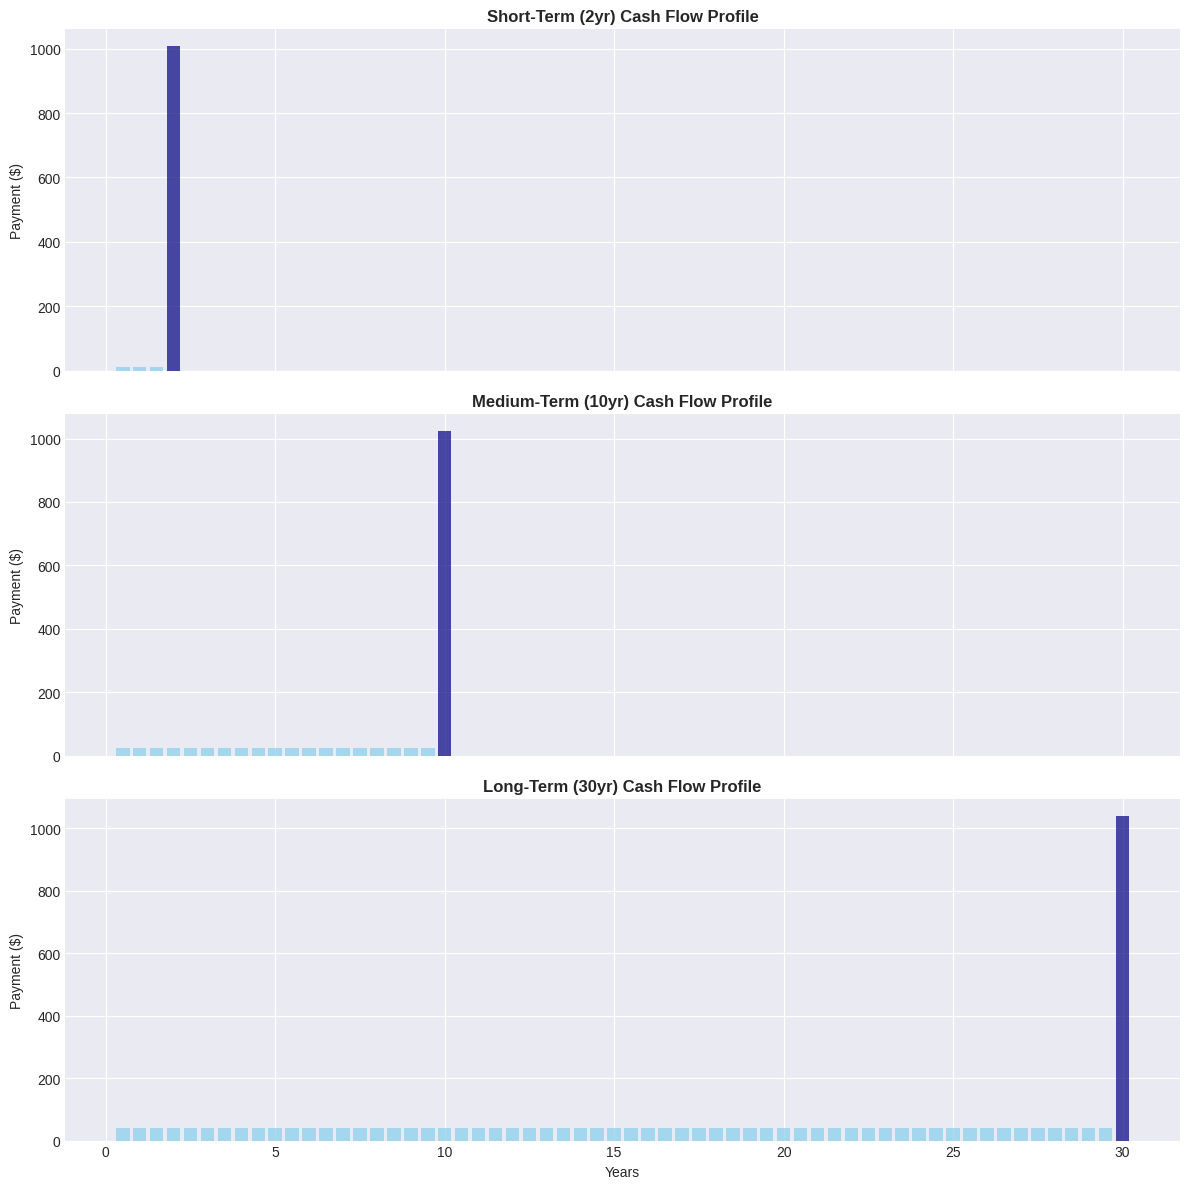

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, (name, metrics) in enumerate(bond_objects.items()):
    ax = axes[i]
    periods = metrics['Periods']
    flows = metrics['Cash_Flows']

    # Color logic: Highlight the final principal payment
    colors = ['skyblue'] * (len(flows) - 1) + ['navy']

    ax.bar(periods, flows, width=0.4, color=colors, alpha=0.7)
    ax.set_title(f'{name} Cash Flow Profile', fontweight='bold')
    ax.set_ylabel('Payment ($)')

plt.xlabel('Years')
plt.tight_layout()
plt.show()

## 5. PORTFOLIO CONSTRUCTION

We will now construct a portfolio. Let's assume we have **$1,000,000** to invest.

**Target Allocation:**
* 40% in Short-Term (Safe)
* 40% in Medium-Term (Core)
* 20% in Long-Term (Aggressive)

We calculate the **Portfolio Duration**, which measures the aggregate sensitivity to interest rates.

In [5]:
# Portfolio Config
total_investment = 1_000_000
weights = np.array([0.40, 0.40, 0.20]) # Short, Medium, Long

# Calculate Portfolio Weighted Metrics
durations = df_bonds['Mod_Duration'].values
convexities = df_bonds['Convexity'].values

port_duration = np.sum(weights * durations)
port_convexity = np.sum(weights * convexities)

print("="*40)
print("PORTFOLIO RISK METRICS")
print("="*40)
print(f"Investment Amount: ${total_investment:,.2f}")
print(f"Portfolio Modified Duration: {port_duration:.4f} years")
print(f"Portfolio Convexity: {port_convexity:.4f}")
print("="*40)

PORTFOLIO RISK METRICS
Investment Amount: $1,000,000.00
Portfolio Modified Duration: 6.5224 years
Portfolio Convexity: 85.6129


## 6. MONTE CARLO SIMULATION: VALUE AT RISK (VaR)

Instead of just simulating a single +1% shock, we will simulate **10,000 potential future interest rate scenarios** based on market volatility.

This allows us to calculate **Value at Risk (VaR)**: *"With 95% confidence, what is the maximum we could lose?"*

**Assumptions:**
* Current Market Yield: 5%
* Annual Rate Volatility: 1% (100 basis points)
* Horizon: 1 Year

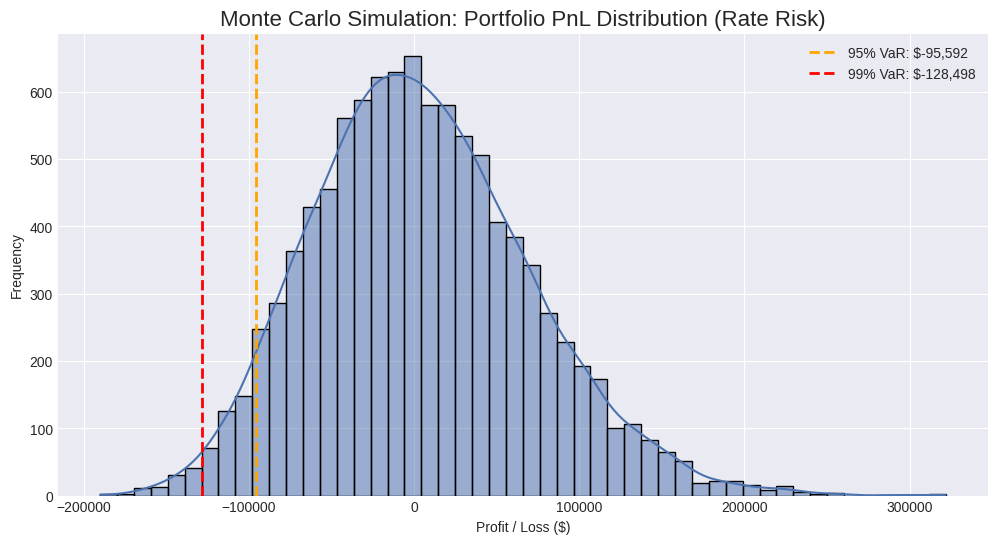

In [6]:
# Simulation Parameters
n_simulations = 10000
current_yield_avg = 0.05
volatility = 0.01 # 100 bps volatility standard deviation

# 1. Generate random yield shocks (Normal Distribution)
np.random.seed(42)
yield_changes = np.random.normal(0, volatility, n_simulations)

# 2. Apply Duration-Convexity Approximation to Portfolio
# Formula: %Change = -Duration*dy + 0.5*Convexity*dy^2
pct_changes = (-port_duration * yield_changes) + (0.5 * port_convexity * (yield_changes**2))

# 3. Calculate PnL (Profit and Loss)
dollar_pnl = total_investment * pct_changes

# 4. Calculate VaR (95% and 99%)
var_95 = np.percentile(dollar_pnl, 5)
var_99 = np.percentile(dollar_pnl, 1)

# Visualization
plt.figure(figsize=(12, 6))
sns.histplot(dollar_pnl, kde=True, color="#4c72b0", bins=50)

# Add VaR Lines
plt.axvline(var_95, color='orange', linestyle='--', linewidth=2, label=f'95% VaR: ${var_95:,.0f}')
plt.axvline(var_99, color='red', linestyle='--', linewidth=2, label=f'99% VaR: ${var_99:,.0f}')

plt.title('Monte Carlo Simulation: Portfolio PnL Distribution (Rate Risk)', fontsize=16)
plt.xlabel('Profit / Loss ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Interpretation of Results

The histogram above shows the probability distribution of our portfolio's value changes based on random interest rate fluctuations.

1.  **Skew:** You may notice a slight "positive skew" (the tail to the right is longer). This is **Convexity** in action. When rates drop, we gain *more* than we lose when rates rise.
2.  **95% VaR:** The orange line tells us that in 95% of market scenarios, our losses will not exceed this amount. This is a critical metric for banking and fund management risk limits.